In [1]:
import os

# change JAX GPU memory preallocation fraction
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'

# !nvidia-smi --query-gpu=gpu_name --format=csv,noheader

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit

import blackjax
from datetime import date
from blackjax.util import run_inference_algorithm

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [2]:

def rfftnfreq_2d(shape, spacing, dtype=np.float64):
    """Broadcastable "``sparse``" wavevectors for ``numpy.fft.rfftn``.

    Parameters
    ----------
    shape : tuple of int
        Shape of ``rfftn`` input.
    spacing : float or None, optional
        Grid spacing. None is equivalent to a 2π spacing, with a wavevector period of 1.
    dtype : dtype_like

    Returns
    -------
    kvec : list of jax.numpy.ndarray
        Wavevectors.

    """
    freq_period = 1
    if spacing is not None:
        freq_period = 2 * np.pi / spacing

    kvec = []
    for axis, s in enumerate(shape[:-1]):
        k = np.fft.fftfreq(s).astype(dtype) * freq_period
        kvec.append(k)

    k = np.fft.rfftfreq(shape[-1]).astype(dtype) * freq_period
    kvec.append(k)

    kvec = np.meshgrid(*kvec, indexing='ij', sparse=True)

    return kvec

In [3]:
##### Spatial parameters

nc = 128*4
bs = 100

ptcl_spacing = bs/nc
ptcl_grid_shape = (nc,) * 2



kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))

from scipy import interpolate

eps=10**(-6)

def ps_test(k):
    return (k+eps)**(-1)

nmodes = 10
kbins = np.linspace(10**(-0.5),k.max(),nmodes)
pk_vals_0 = ps_test((kbins[1:]+kbins[:-1])/2)


bp = jnp.hstack([pk_vals_0])


kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
kplot = (kbins[1:]+kbins[:-1])/2

kbins[0] = -0.1
kbins[-1] = 100

def power3d(k,theta):
    val = jnp.interp(k,jnp.array(kplot),theta)
    return val

Plin = power3d(k, pk_vals_0)



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


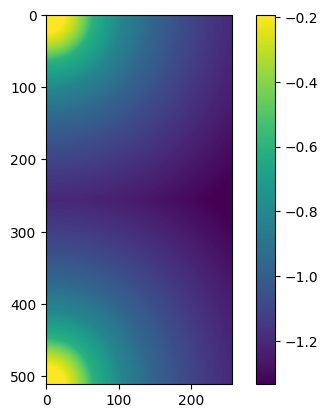

In [4]:

#visualize transfer func
%pylab inline
imshow(np.log10(Plin))
colorbar()
show()


In [5]:
from jax import jit, checkpoint, custom_vjp
from functools import partial

In [6]:
nx = nc
ny = nc

kx = jnp.ones(k.shape)*kvec[0]
ky = jnp.ones(k.shape)*kvec[1]
from jax import jit, checkpoint, custom_vjp

@jit
@checkpoint
def linear_modes(modes, theta):
    kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
    k = jnp.sqrt(sum(k**2 for k in kvec))

    Plin = power3d(k, theta)
    
    if jnp.isrealobj(modes):
        modes = jnp.fft.rfftn(modes, norm='ortho')
    modes *= jnp.sqrt(Plin)#*jnp.sqrt(10)
    return modes


def gen_map_den2d(theta,z):
    modes_e = z[:nx*ny].reshape((nx,ny))
    
    theta_e = theta[:nmodes-1]
    
    phi_e = linear_modes(modes_e, theta_e)
  
    return jnp.fft.irfftn(phi_e )#Need to check normalization



In [7]:
error_val=1.0

def sample_x_z(key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nx*ny,))
        x = (gen_map_den2d(θ,z) + error_val*jax.random.normal(keys[1], (nx,ny))) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
        return (x, z)

In [8]:
stheta = jnp.array(bp)

(xx,zz) = sample_x_z(rng_key,stheta)

/var/folders/v9/977m2z015_b794hqf_nk0q1r0000gn/T/ipykernel_9090/2948050034.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))


In [9]:
x = xx

n_bp = nmodes-1

def logLike_MCHMC(v):
        z = v[n_bp:]
        
        #θ = stheta
        θ = v[:n_bp]
        #θ=θ.at[1].set(v[1])
        return logLike(z,θ)+logPrior(θ)

def logLike(z, θ):
        return -(jnp.sum((x - gen_map_den2d(θ,z))**2) + jnp.sum(z**2.0))

def logPrior(θ): #20% error on power spectra prior
        return -1/2.*jnp.sum(((θ-jnp.array(bp))/(0.2*bp))**2)
    

In [10]:
(xx,zz) = sample_x_z(rng_key,jnp.array(bp))

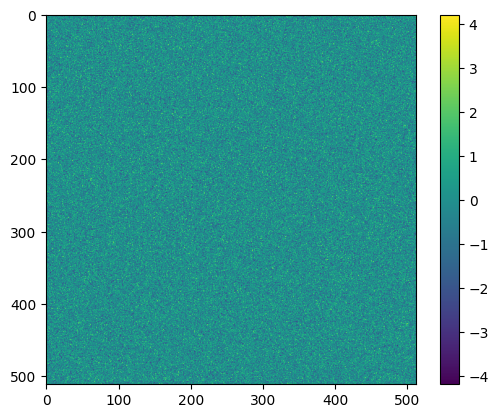

In [11]:
imshow(xx)
colorbar()

In [12]:
### import time

initial_position = numpy.random.rand(
    nx*ny+n_bp)

initial_position[:n_bp] = stheta
initial_position[n_bp:]= zz

initial_position= jnp.array(initial_position)

init_key, run_key = jax.random.split(rng_key, 2)


In [13]:
logLike(zz,stheta)

Array(-523943.2, dtype=float32)

In [14]:
logLike_MCHMC(initial_position)

Array(-523943.2, dtype=float32)

In [15]:
test = jax.value_and_grad(logLike_MCHMC)

In [16]:
test(initial_position)[1]

Array([ 0.04963145,  0.33424047,  0.25291544, ..., -1.4300569 ,
        0.35728773,  1.0381758 ], dtype=float32)

In [20]:
    def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
        init_key, tune_key, run_key = jax.random.split(key, 3)

        # create an initial state for the sampler
        initial_state = blackjax.mcmc.mclmc.init(
            position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
        )

        # build the kernel
        kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
            logdensity_fn=logdensity_fn,
            integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
            inverse_mass_matrix=inverse_mass_matrix,
        )
        # jax.debug.print("{x} state before tuning", x=initial_state)

        # find values for L and step_size
        (
            blackjax_state_after_tuning,
            blackjax_mclmc_sampler_params,
        ) = blackjax.mclmc_find_L_and_step_size(
            mclmc_kernel=kernel,
            num_steps=num_steps,
            state=initial_state,
            rng_key=tune_key,
            frac_tune2=0.0,
            frac_tune3=0.0,
            diagonal_preconditioning=False,
        )
        # jax.debug.print("{x} state after tuning", x=(blackjax_state_after_tuning))
        jax.debug.print("{x} params after tuning", x=(blackjax_mclmc_sampler_params))

        # L = 0.47224498
        # step_size = 1.1806124


        # use the quick wrapper to build a new kernel with the tuned parameters
        sampling_alg = blackjax.mclmc(
            logdensity_fn,
            L=blackjax_mclmc_sampler_params.L,
            step_size=blackjax_mclmc_sampler_params.step_size,
            # L=L,
            # step_size=step_size,
        )

        # run the sampler
        _, samples = blackjax.util.run_inference_algorithm(
            rng_key=run_key,
            initial_state=initial_state,
            # initial_state=initial_state,
            inference_algorithm=sampling_alg,
            num_steps=num_steps,
            transform=transform,
            progress_bar=True,
        )

        return samples

In [21]:
# run the algorithm on a high dimensional gaussian, and show two of the dimensions

sample_key, rng_key = jax.random.split(jax.random.PRNGKey(0))
samples = run_mclmc(
    logdensity_fn=logLike_MCHMC,
    num_steps=100,
    initial_position=initial_position,
    key=sample_key,
    transform=lambda state, info: state.position,
)
# samples.mean()

MCLMCAdaptationState(L=Array(512.0088, dtype=float32, weak_type=True), step_size=Array(8.381907, dtype=float32), inverse_mass_matrix=Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)) params after tuning


In [22]:
samples[:,0]

Array([0.6468551 , 0.65548676, 0.670754  , 0.689412  , 0.70583284,
       0.71842927, 0.72429764, 0.7245244 , 0.7241995 , 0.7247708 ,
       0.72091883, 0.7101185 , 0.69319063, 0.6740377 , 0.65316707,
       0.6355968 , 0.61843157, 0.601708  , 0.5829655 , 0.564822  ,
       0.5471881 , 0.5333969 , 0.5213777 , 0.51441365, 0.50895333,
       0.50976133, 0.5136491 , 0.5155525 , 0.51911294, 0.5227102 ,
       0.52753186, 0.52905416, 0.53363305, 0.54205614, 0.5493815 ,
       0.55799204, 0.56743217, 0.5799923 , 0.59268713, 0.6111743 ,
       0.6285039 , 0.64339113, 0.65564847, 0.66382384, 0.6720996 ,
       0.67403936, 0.67161304, 0.66863465, 0.6636186 , 0.6595507 ,
       0.6542391 , 0.64614046, 0.63582927, 0.62648594, 0.61836904,
       0.61129886, 0.6038167 , 0.59897655, 0.6017701 , 0.6053583 ,
       0.61001915, 0.61778826, 0.6246231 , 0.6308198 , 0.64019614,
       0.6460615 , 0.6530324 , 0.65688264, 0.66247606, 0.66395026,
       0.66401786, 0.6590755 , 0.6603614 , 0.6642767 , 0.66784

In [ ]:
## trying now with HMC

In [43]:
inv_mass_matrix = 0.1*np.ones(initial_position.shape)
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logLike_MCHMC, step_size, inv_mass_matrix, num_integration_steps)

In [45]:
inv_mass_matrix = 0.1*np.ones(initial_position.shape)
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logLike_MCHMC, step_size, inv_mass_matrix, num_integration_steps)
initial_state = hmc.init(initial_position)
hmc_kernel = jax.jit(hmc.step)
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [46]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [47]:

rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position

In [49]:
mcmc_samples

Array([[ 0.6504387 ,  0.24274299,  0.15356445, ..., -0.87909985,
        -0.01715962,  0.16259634],
       [ 0.65750396,  0.24745658,  0.16698098, ..., -0.83709276,
        -0.00583628,  0.16081564],
       [ 0.65000767,  0.25331795,  0.16473027, ..., -0.84151405,
         0.00298525,  0.14525856],
       ...,
       [ 0.39241785,  0.26157495,  0.14497532, ..., -0.94360906,
        -0.4939656 , -0.5946844 ],
       [ 0.40526286,  0.24423306,  0.19233069, ..., -0.9641542 ,
        -0.51992977, -0.573494  ],
       [ 0.40380293,  0.23175626,  0.17530905, ..., -0.99857   ,
        -0.49198765, -0.5541305 ]], dtype=float32)

(array([ 234.,  762., 1839., 2744., 2299., 1418.,  482.,  135.,   59.,
          28.]),
 array([0.27044848, 0.36703825, 0.46362799, 0.56021774, 0.65680754,
        0.75339723, 0.84998703, 0.94657683, 1.04316652, 1.13975632,
        1.23634601]),
 <BarContainer object of 10 artists>)

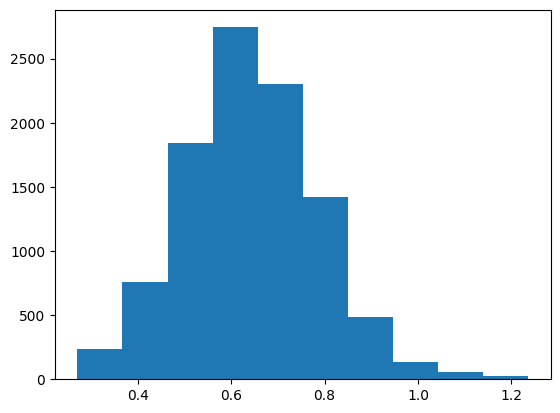

In [52]:
plt.hist(mcmc_samples[:,0])